In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset

# -------- Data Loading Function --------
def load_data(folder_path):
    all_data = []
    for file in sorted(os.listdir(folder_path)):
        if file.endswith('.csv'):
            file_path = os.path.join(folder_path, file)
            df = pd.read_csv(file_path)
            if '5 Minutes' in df.columns and 'Flow (Veh/5 Minutes)' in df.columns:
                # Convert timestamp column to datetime
                df['5 Minutes'] = pd.to_datetime(df['5 Minutes'], errors='coerce')
                # Set timestamp as the index
                df = df.set_index('5 Minutes')
                # Append only the required column
                all_data.append(df[['Flow (Veh/5 Minutes)']])
    
    # Concatenate all dataframes
    combined_data = pd.concat(all_data)
    
    # Sort by the timestamp index
    combined_data = combined_data.sort_index()
    
    # Drop any rows with missing values
    combined_data = combined_data.dropna()
    
    return combined_data

In [66]:
# Load data for each node
folder_402214 = 'Data/402214'
folder_402510 = 'Data/402510'
folder_402835 = 'Data/402835'
folder_414025 = 'Data/414025'

data_402214 = load_data(folder_402214)
data_402510 = load_data(folder_402510)
data_402835 = load_data(folder_402835)
data_414025 = load_data(folder_414025)

# Find the common date range
common_start = max(data_402214.index.min(), data_402510.index.min(), data_402835.index.min(), data_414025.index.min())
common_end = min(data_402214.index.max(), data_402510.index.max(), data_402835.index.max(), data_414025.index.max())

# Create a common date range with 5-minute intervals
common_index = pd.date_range(start=common_start, end=common_end, freq='5T')

# Reindex and interpolate data for each node
data_402214 = data_402214.reindex(common_index).interpolate()
data_402510 = data_402510.reindex(common_index).interpolate()
data_402835 = data_402835.reindex(common_index).interpolate()
data_414025 = data_414025.reindex(common_index).interpolate()

# Stack the data for all nodes
node_data = np.stack([
    data_402214.values,
    data_402510.values,
    data_402835.values,
    data_414025.values
], axis=0)

# Normalize the data using MinMaxScaler
scalers = [MinMaxScaler() for _ in range(node_data.shape[0])]
for i in range(node_data.shape[0]):
    # Apply MinMaxScaler to each node's data, no need to flatten
    node_data[i] = scalers[i].fit_transform(node_data[i].reshape(-1, 1))

# Transpose the data to shape (num_timesteps, num_nodes, num_features)
node_data = np.transpose(node_data, (1, 0, 2))  # Shape: (num_timesteps, num_nodes, num_features)


In [67]:
# -------- 2. Create Adjacency Matrix --------
# Load the adjacency matrix (connectivity between nodes)
adj_matrix = pd.read_csv('Data/adj.csv', header=None).values

# Normalize the adjacency matrix
def normalize_adjacency_matrix(adj):
    D = np.diag(np.sum(adj, axis=1))
    D_inv = np.linalg.inv(D)
    adj_normalized = np.dot(D_inv, adj)
    return adj_normalized

adj_normalized = normalize_adjacency_matrix(adj_matrix)
# Ensure adj_normalized is a PyTorch tensor with correct shape
adj_normalized = adj_normalized[:4, :4]  # Keep only the first 4x4 submatrix
adj_normalized = torch.tensor(adj_normalized, dtype=torch.float32)
print("Shape of adj_normalized:", adj_normalized.shape)

Shape of adj_normalized: torch.Size([4, 4])


In [68]:
# -------- 3. Prepare the Data --------
# Split the data into training, validation, and test sets
train_size = int(0.7 * len(node_data))
val_size = int(0.15 * len(node_data))
test_size = len(node_data) - train_size - val_size

train_data, val_data, test_data = np.split(node_data, [train_size, train_size + val_size])

# Create DataLoader for train, val, and test data
def create_dataloader(data, batch_size, input_window=30, output_window=10):
    X, Y = [], []
    for i in range(len(data) - input_window - output_window + 1):
        X.append(data[i:i+input_window])
        Y.append(data[i+input_window:i+input_window+output_window])
    X = torch.tensor(np.array(X), dtype=torch.float32)
    Y = torch.tensor(np.array(Y), dtype=torch.float32)
    dataset = TensorDataset(X, Y)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

batch_size = 32
train_loader = create_dataloader(train_data, batch_size, input_window=30, output_window=10)
val_loader = create_dataloader(val_data, batch_size, input_window=30, output_window=10)
test_loader = create_dataloader(test_data, batch_size, input_window=30, output_window=10)


In [69]:
print("Shape of node_data:", node_data.shape)
train_loader = create_dataloader(train_data, batch_size)
val_loader = create_dataloader(val_data, batch_size)
test_loader = create_dataloader(test_data, batch_size)

# Print shapes of a batch from train_loader
for X_batch, Y_batch in train_loader:
    print("Shape of X_batch:", X_batch.shape)
    print("Shape of Y_batch:", Y_batch.shape)
    break

Shape of node_data: (24192, 4, 1)
Shape of X_batch: torch.Size([32, 30, 4, 1])
Shape of Y_batch: torch.Size([32, 10, 4, 1])


In [70]:
# -------- 4. Build the Model --------

# GCN Layer
class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super(GCNLayer, self).__init__()
        self.fc = nn.Linear(in_features, out_features)

    def forward(self, x, adj):
        # x shape: (batch_size, num_nodes, in_features)
        # adj shape: (num_nodes, num_nodes)

        # Multiply x with adjacency matrix on the node dimension
        out = torch.einsum('bni,nj->bni', x, adj)
        out = self.fc(out)
        return torch.relu(out)


# GCN Model
class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.gcn1 = GCNLayer(input_dim, hidden_dim)
        self.gcn2 = GCNLayer(hidden_dim, output_dim)

    def forward(self, x, adj):
        x = self.gcn1(x, adj)
        x = self.gcn2(x, adj)
        return x

# Combined GNN + LSTM Model
class GNN_LSTM_Model(nn.Module):
    def __init__(self, num_nodes, input_dim, gnn_hidden_dim, lstm_hidden_dim, output_dim, output_window):
        super(GNN_LSTM_Model, self).__init__()
        self.gcn = GCN(input_dim, gnn_hidden_dim, gnn_hidden_dim)
        self.lstm = nn.LSTM(gnn_hidden_dim * num_nodes, lstm_hidden_dim, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_dim, num_nodes * output_dim * output_window)
        self.num_nodes = num_nodes
        self.output_dim = output_dim
        self.output_window = output_window

    def forward(self, x, adj):
        # x shape: (batch_size, input_window, num_nodes, input_dim)
        batch_size, input_window, num_nodes, input_dim = x.shape
        
        gnn_out = []
        for t in range(input_window):
            gnn_output = self.gcn(x[:, t, :, :], adj)  # (batch_size, num_nodes, gnn_hidden_dim)
            gnn_out.append(gnn_output)
        
        # Stack GNN outputs
        gnn_out = torch.stack(gnn_out, dim=1)  # (batch_size, input_window, num_nodes, gnn_hidden_dim)
        
        # Reshape for LSTM input
        lstm_in = gnn_out.view(batch_size, input_window, -1)
        
        # Pass through LSTM
        lstm_out, _ = self.lstm(lstm_in)  # (batch_size, input_window, lstm_hidden_dim)
        
        # Use only the last output from LSTM
        fc_in = lstm_out[:, -1, :]
        
        # Pass through fully connected layer
        fc_out = self.fc(fc_in)  # (batch_size, num_nodes * output_dim * output_window)
        
        # Reshape output to (batch_size, output_window, num_nodes, output_dim)
        output = fc_out.view(batch_size, self.output_window, self.num_nodes, self.output_dim)
        
        return output

# Model instantiation
num_nodes = 4
input_dim = 1
gnn_hidden_dim = 64
lstm_hidden_dim = 128
output_dim = 1
output_window = 10

model = GNN_LSTM_Model(num_nodes, input_dim, gnn_hidden_dim, lstm_hidden_dim, output_dim, output_window)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [71]:
print("Shape of adj_normalized:", adj_normalized.shape)

Shape of adj_normalized: torch.Size([4, 4])


In [73]:
# -------- 5. Train the Model --------
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import pickle

def train_model(model, train_loader, val_loader, adj, num_epochs=20, patience=10):
    best_val_loss = float('inf')
    best_model = None
    epochs_no_improve = 0
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        
        # Use tqdm for the progress bar
        train_bar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        
        for X_batch, Y_batch in train_bar:
            optimizer.zero_grad()

            # Forward pass
            predictions = model(X_batch, adj)
            loss = criterion(predictions, Y_batch)

            # Backpropagation
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            
            # Update progress bar
            train_bar.set_postfix({'Train Loss': f'{train_loss/(train_bar.n+1):.4f}'})

        # Validation loss
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for X_val, Y_val in val_loader:
                val_predictions = model(X_val, adj)
                val_loss += criterion(val_predictions, Y_val).item()

        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        
        print(f'Epoch {epoch + 1}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
        
        # Check if this is the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            best_model = model.state_dict()
            epochs_no_improve = 0
            
            # Save the best model
            torch.save(best_model, 'best_model.pth')
            
            # Save the MinMax scalers
            with open('scalers.pkl', 'wb') as f:
                pickle.dump(scalers, f)
            
            print(f"Saved new best model with validation loss: {best_val_loss:.4f}")
        else:
            epochs_no_improve += 1
        
        # Early stopping
        if epochs_no_improve == patience:
            print(f"Early stopping triggered after {patience} epochs without improvement.")
            break

    return best_model

# Ensure adj_normalized is a PyTorch tensor with correct shape
adj_normalized = adj_normalized[:4, :4]  # Keep only the first 4x4 submatrix
adj_normalized = torch.tensor(adj_normalized, dtype=torch.float32)

best_model = train_model(model, train_loader, val_loader, adj_normalized, num_epochs=50, patience=10)

# Load the best model
model.load_state_dict(torch.load('best_model.pth'))

<ipython-input-73-02ecb9d90234>:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  adj_normalized = torch.tensor(adj_normalized, dtype=torch.float32)
Epoch 1/50: 100%|██████████| 528/528 [00:16<00:00, 32.22it/s, Train Loss=0.0028]


Epoch 1, Train Loss: 0.0028, Val Loss: 0.0022
Saved new best model with validation loss: 0.0022


Epoch 2/50: 100%|██████████| 528/528 [00:15<00:00, 33.94it/s, Train Loss=0.0027]


Epoch 2, Train Loss: 0.0027, Val Loss: 0.0023


Epoch 3/50: 100%|██████████| 528/528 [00:16<00:00, 32.75it/s, Train Loss=0.0027]


Epoch 3, Train Loss: 0.0027, Val Loss: 0.0024


Epoch 4/50: 100%|██████████| 528/528 [00:15<00:00, 33.30it/s, Train Loss=0.0026]


Epoch 4, Train Loss: 0.0026, Val Loss: 0.0022
Saved new best model with validation loss: 0.0022


Epoch 5/50: 100%|██████████| 528/528 [00:15<00:00, 33.63it/s, Train Loss=0.0026]


Epoch 5, Train Loss: 0.0026, Val Loss: 0.0022


Epoch 6/50: 100%|██████████| 528/528 [00:17<00:00, 29.42it/s, Train Loss=0.0025]


Epoch 6, Train Loss: 0.0025, Val Loss: 0.0021
Saved new best model with validation loss: 0.0021


Epoch 7/50: 100%|██████████| 528/528 [00:16<00:00, 31.41it/s, Train Loss=0.0025]


Epoch 7, Train Loss: 0.0025, Val Loss: 0.0021


Epoch 8/50: 100%|██████████| 528/528 [00:16<00:00, 32.79it/s, Train Loss=0.0025]


Epoch 8, Train Loss: 0.0025, Val Loss: 0.0022


Epoch 9/50: 100%|██████████| 528/528 [00:15<00:00, 33.17it/s, Train Loss=0.0025]


Epoch 9, Train Loss: 0.0024, Val Loss: 0.0022


Epoch 10/50: 100%|██████████| 528/528 [00:15<00:00, 33.29it/s, Train Loss=0.0024]


Epoch 10, Train Loss: 0.0024, Val Loss: 0.0022


Epoch 11/50: 100%|██████████| 528/528 [00:17<00:00, 29.55it/s, Train Loss=0.0024]


Epoch 11, Train Loss: 0.0024, Val Loss: 0.0021
Saved new best model with validation loss: 0.0021


Epoch 12/50: 100%|██████████| 528/528 [00:17<00:00, 29.35it/s, Train Loss=0.0024]


Epoch 12, Train Loss: 0.0024, Val Loss: 0.0021


Epoch 13/50: 100%|██████████| 528/528 [00:14<00:00, 36.25it/s, Train Loss=0.0023]


Epoch 13, Train Loss: 0.0023, Val Loss: 0.0020
Saved new best model with validation loss: 0.0020


Epoch 14/50: 100%|██████████| 528/528 [00:14<00:00, 36.55it/s, Train Loss=0.0023]


Epoch 14, Train Loss: 0.0023, Val Loss: 0.0020


Epoch 15/50: 100%|██████████| 528/528 [00:14<00:00, 36.50it/s, Train Loss=0.0023]


Epoch 15, Train Loss: 0.0023, Val Loss: 0.0021


Epoch 16/50: 100%|██████████| 528/528 [00:16<00:00, 32.29it/s, Train Loss=0.0023]


Epoch 16, Train Loss: 0.0023, Val Loss: 0.0021


Epoch 17/50: 100%|██████████| 528/528 [00:16<00:00, 32.17it/s, Train Loss=0.0022]


Epoch 17, Train Loss: 0.0022, Val Loss: 0.0021


Epoch 18/50: 100%|██████████| 528/528 [00:17<00:00, 30.32it/s, Train Loss=0.0022]


Epoch 18, Train Loss: 0.0022, Val Loss: 0.0021


Epoch 19/50: 100%|██████████| 528/528 [00:14<00:00, 35.50it/s, Train Loss=0.0022]


Epoch 19, Train Loss: 0.0022, Val Loss: 0.0021


Epoch 20/50: 100%|██████████| 528/528 [00:14<00:00, 36.07it/s, Train Loss=0.0022]


Epoch 20, Train Loss: 0.0022, Val Loss: 0.0022


Epoch 21/50: 100%|██████████| 528/528 [00:15<00:00, 34.83it/s, Train Loss=0.0022]


Epoch 21, Train Loss: 0.0022, Val Loss: 0.0021


Epoch 22/50: 100%|██████████| 528/528 [00:14<00:00, 35.44it/s, Train Loss=0.0021]


Epoch 22, Train Loss: 0.0021, Val Loss: 0.0021


Epoch 23/50: 100%|██████████| 528/528 [00:14<00:00, 36.63it/s, Train Loss=0.0021]


Epoch 23, Train Loss: 0.0021, Val Loss: 0.0021
Early stopping triggered after 10 epochs without improvement.


<ipython-input-73-02ecb9d90234>:80: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


<All keys matched successfully>

In [74]:
# -------- 6. Test the Model --------
def evaluate_model(model, test_loader, adj):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for X_test, Y_test in test_loader:
            predictions = model(X_test, adj)
            test_loss += criterion(predictions, Y_test).item()
    print(f'Test Loss: {test_loss/len(test_loader):.4f}')

evaluate_model(model, test_loader, adj_normalized)

Test Loss: 0.0039


In [76]:
# -------- 7. Make Predictions --------
# To make predictions on new data
def predict(model, X_new, adj):
    model.eval()
    with torch.no_grad():
        return model(X_new, adj)

# Example prediction
new_data = torch.tensor(test_data[-30:].reshape(1, 30, 4, 1), dtype=torch.float32)  # Last 30 timesteps
predicted_flow_normalized = predict(model, new_data, adj_normalized)

# Inverse normalization (back to original scale)
predicted_flow = np.zeros_like(predicted_flow_normalized.detach().numpy())

# Apply inverse transform for each node
for i in range(num_nodes):
    # Reshape to 2D array for inverse_transform
    node_predictions = predicted_flow_normalized[0, :, i, 0].detach().numpy().reshape(-1, 1)
    predicted_flow[0, :, i, 0] = scalers[i].inverse_transform(node_predictions).flatten()

print("Non-normalized predicted flow for next 10 timesteps:")
for t in range(10):
    print(f"Timestep {t+1}:")
    for node in range(num_nodes):
        print(f"  Node {node+1}: {predicted_flow[0, t, node, 0]:.2f}")

Non-normalized predicted flow for next 10 timesteps:
Timestep 1:
  Node 1: 52.28
  Node 2: 67.96
  Node 3: 11.05
  Node 4: 25.38
Timestep 2:
  Node 1: 49.17
  Node 2: 66.18
  Node 3: 12.44
  Node 4: 25.97
Timestep 3:
  Node 1: 47.55
  Node 2: 65.84
  Node 3: 13.13
  Node 4: 25.82
Timestep 4:
  Node 1: 44.91
  Node 2: 63.79
  Node 3: 12.06
  Node 4: 23.69
Timestep 5:
  Node 1: 43.44
  Node 2: 64.06
  Node 3: 11.49
  Node 4: 22.55
Timestep 6:
  Node 1: 41.92
  Node 2: 63.82
  Node 3: 11.67
  Node 4: 23.75
Timestep 7:
  Node 1: 39.00
  Node 2: 64.39
  Node 3: 12.27
  Node 4: 21.77
Timestep 8:
  Node 1: 37.23
  Node 2: 61.60
  Node 3: 10.36
  Node 4: 20.06
Timestep 9:
  Node 1: 35.99
  Node 2: 61.20
  Node 3: 9.99
  Node 4: 17.87
Timestep 10:
  Node 1: 34.36
  Node 2: 60.36
  Node 3: 11.09
  Node 4: 17.97


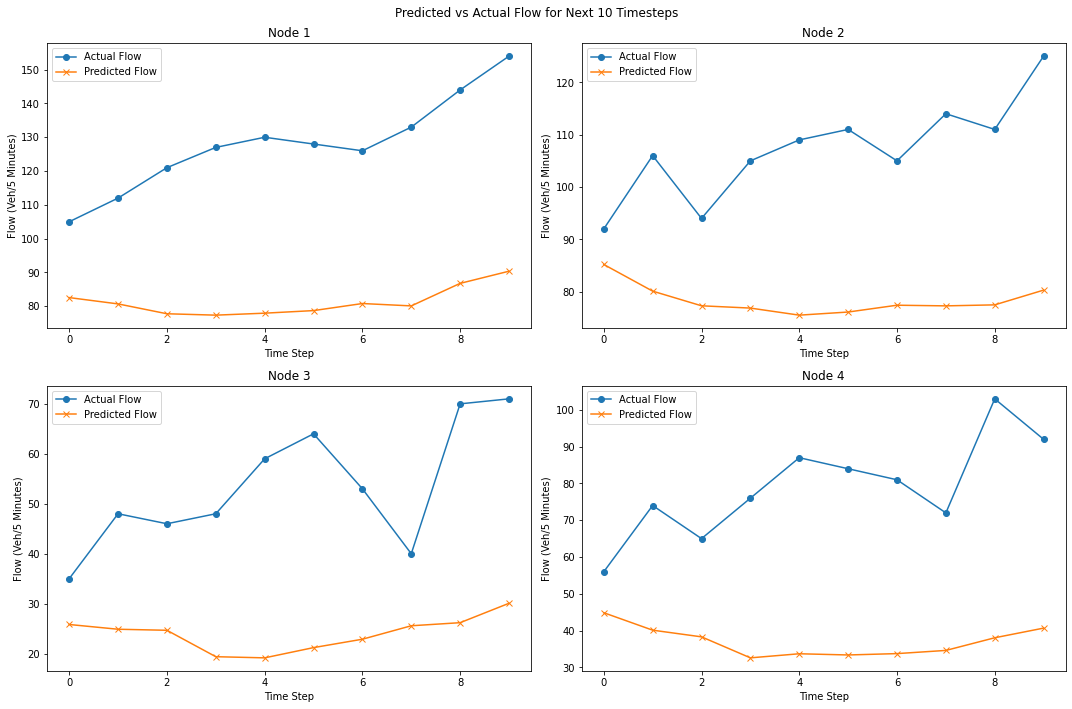

Mean Absolute Error (MAE): 36.7342
Root Mean Squared Error (RMSE): 39.4489
R-squared (R2) Score: -0.6610


In [81]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# -------- 8. Visualize Training and Validation Loss --------
# This function remains unchanged as it's not directly related to the new plotting requirement

# -------- 9. Evaluate the Model on Test Set and Visualize Predictions --------
def evaluate_and_plot_results(model, test_loader, adj, scalers):
    model.eval()
    with torch.no_grad():
        # Get the last batch from the test loader
        for X_test, Y_test in test_loader:
            pass
        
        # Use the last 10 timesteps to predict the next 10
        input_sequence = X_test[-1:, -10:, :, :]  # Shape: [1, 10, num_nodes, 1]
        actual_next_10 = Y_test[-1:, :10, :, :]  # Shape: [1, 10, num_nodes, 1]
        
        # Predict next 10 timesteps
        predicted_next_10 = model(input_sequence, adj)
        
        # Denormalize the predictions and actual values
        denorm_predictions = np.zeros_like(predicted_next_10.numpy())
        denorm_actuals = np.zeros_like(actual_next_10.numpy())
        
        for i in range(num_nodes):
            denorm_predictions[0, :, i, 0] = scalers[i].inverse_transform(
                predicted_next_10[0, :, i, 0].reshape(-1, 1)).flatten()
            denorm_actuals[0, :, i, 0] = scalers[i].inverse_transform(
                actual_next_10[0, :, i, 0].reshape(-1, 1)).flatten()
    
    # Plot predictions vs actual values for each node
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Predicted vs Actual Flow for Next 10 Timesteps')
    
    for i, ax in enumerate(axs.flat):
        ax.plot(range(10), denorm_actuals[0, :, i, 0], label='Actual Flow', marker='o')
        ax.plot(range(10), denorm_predictions[0, :, i, 0], label='Predicted Flow', marker='x')
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Flow (Veh/5 Minutes)')
        ax.set_title(f'Node {i+1}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

    # Calculate evaluation metrics
    mae = mean_absolute_error(denorm_actuals.flatten(), denorm_predictions.flatten())
    rmse = np.sqrt(mean_squared_error(denorm_actuals.flatten(), denorm_predictions.flatten()))
    r2 = r2_score(denorm_actuals.flatten(), denorm_predictions.flatten())

    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    print(f'R-squared (R2) Score: {r2:.4f}')

# Evaluate model and plot results
evaluate_and_plot_results(model, test_loader, adj_normalized, scalers)


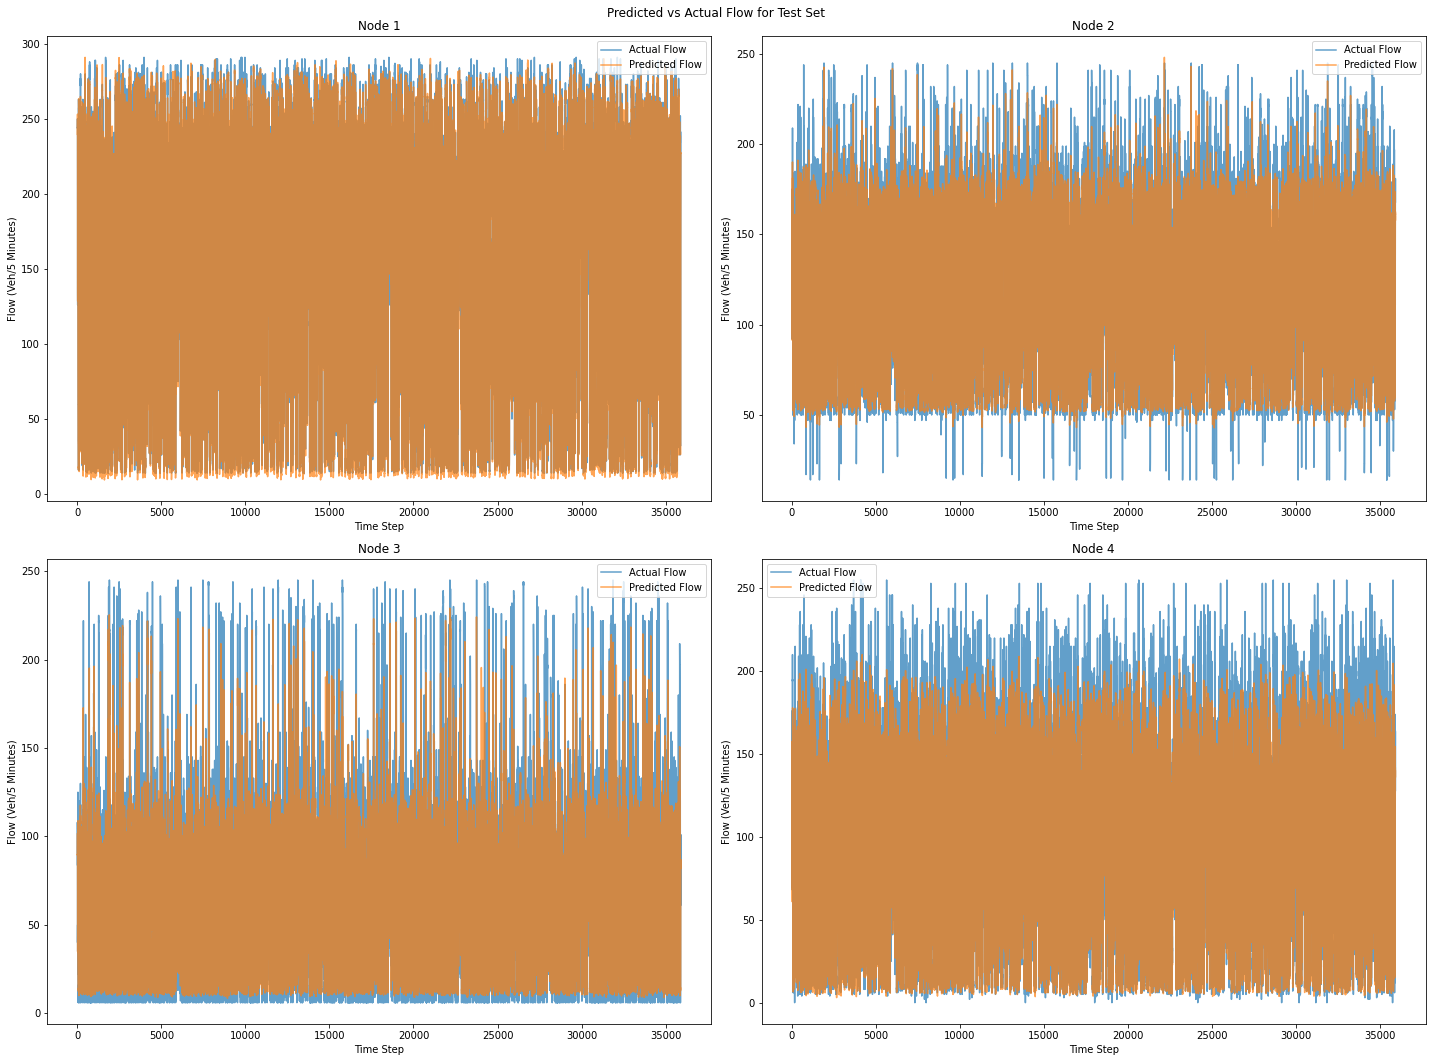

Mean Absolute Error (MAE): 10.1273
Root Mean Squared Error (RMSE): 17.6389
R-squared (R2) Score: 0.9427


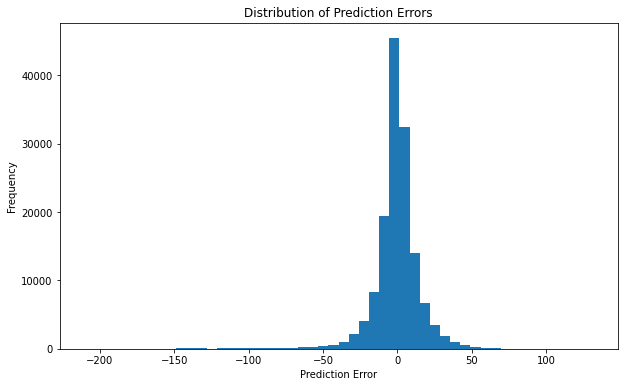

In [82]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def evaluate_and_plot_results(model, test_loader, adj, scalers):
    model.eval()
    all_predictions = []
    all_actuals = []
    
    with torch.no_grad():
        for X_test, Y_test in test_loader:
            # Predict
            predictions = model(X_test, adj)
            
            # Store predictions and actuals
            all_predictions.append(predictions.cpu().numpy())
            all_actuals.append(Y_test.cpu().numpy())
    
    # Concatenate all batches
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_actuals = np.concatenate(all_actuals, axis=0)
    
    # Denormalize the predictions and actual values
    denorm_predictions = np.zeros_like(all_predictions)
    denorm_actuals = np.zeros_like(all_actuals)
    
    for i in range(num_nodes):
        denorm_predictions[:, :, i, 0] = scalers[i].inverse_transform(all_predictions[:, :, i, 0])
        denorm_actuals[:, :, i, 0] = scalers[i].inverse_transform(all_actuals[:, :, i, 0])
    
    # Plot predictions vs actual values for each node
    fig, axs = plt.subplots(2, 2, figsize=(20, 15))
    fig.suptitle('Predicted vs Actual Flow for Test Set')
    
    for i, ax in enumerate(axs.flat):
        ax.plot(denorm_actuals[:, :, i, 0].flatten(), label='Actual Flow', alpha=0.7)
        ax.plot(denorm_predictions[:, :, i, 0].flatten(), label='Predicted Flow', alpha=0.7)
        ax.set_xlabel('Time Step')
        ax.set_ylabel('Flow (Veh/5 Minutes)')
        ax.set_title(f'Node {i+1}')
        ax.legend()
    
    plt.tight_layout()
    plt.show()

    # Calculate evaluation metrics
    mae = mean_absolute_error(denorm_actuals.flatten(), denorm_predictions.flatten())
    rmse = np.sqrt(mean_squared_error(denorm_actuals.flatten(), denorm_predictions.flatten()))
    r2 = r2_score(denorm_actuals.flatten(), denorm_predictions.flatten())

    print(f'Mean Absolute Error (MAE): {mae:.4f}')
    print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')
    print(f'R-squared (R2) Score: {r2:.4f}')

    # Plot overall distribution of errors
    errors = denorm_predictions.flatten() - denorm_actuals.flatten()
    plt.figure(figsize=(10, 6))
    plt.hist(errors, bins=50)
    plt.xlabel('Prediction Error')
    plt.ylabel('Frequency')
    plt.title('Distribution of Prediction Errors')
    plt.show()

# Evaluate model and plot results
evaluate_and_plot_results(model, test_loader, adj_normalized, scalers)